Orginal Data Size: 14642
I/P shape: (160, 320, 3)

--------------------------------------------------------------------------------------



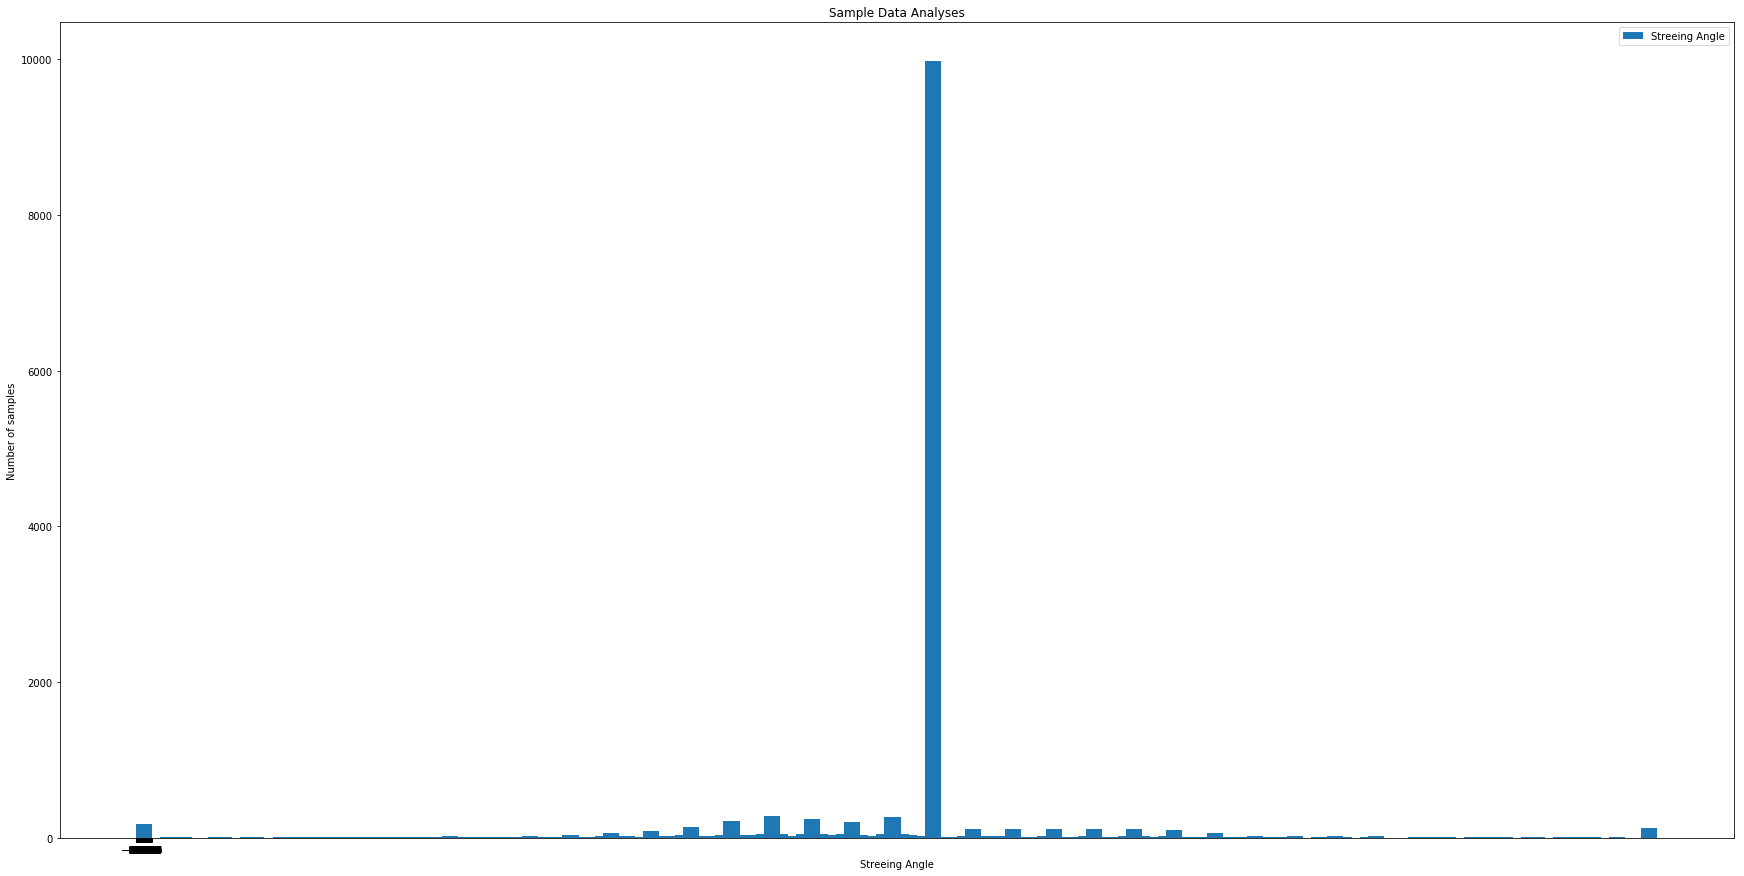

In [4]:
### Model.py to Analyize the Data Histogram

import csv
import cv2
import numpy as np
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import plotly.plotly as py
import sklearn
from sklearn.utils import shuffle

# Load CSV File for Validation Data       
#Get Validation Data (This is Udacity provided same data)
Val_lines = []
with open('DATA/driving_log.csv') as csvfile2 :
    reader = csv.reader(csvfile2)
    for line in reader :
        Val_lines.append(line)
        
Val_images = [] # Validation featuers
Val_measurments = [] # Validation labels

for line in Val_lines :
    #print(line[0])
    Val_source_path = line[0] # to get the center image file name/paths
    Val_file_name = Val_source_path.split('/')[-1]
    #print(file_name)
    Val_current_path = 'DATA/IMG/'+Val_file_name
    Val_image = cv2.imread(Val_current_path)
    Val_images.append(Val_image)
    Val_measurment = float(line[3]) # to get the steering angle from the csv file
    Val_measurments.append(Val_measurment)
    
X_Val = np.array(Val_images)
y_Val = np.array(Val_measurments)
y_Val2 = []
for i in range(len(y_Val)):
    y_Val1 = float(format(y_Val[i], '.2f'))
    y_Val2.append(y_Val1)

unique_angles, counts = np.unique(y_Val2, return_counts=True)
y_pos = range(len(counts))
x_pos= np.arange(len(Val_measurments))
max_count = np.max(counts)

#unique_angles2 = []
#print("unique_angles",unique_angles)

print("Orginal Data Size:",len(X_Val))

print ("I/P shape:", X_Val.shape[1:])
print()
print("--------------------------------------------------------------------------------------\n")    

plt.figure(figsize=(30,15))
pyplot.bar(y_pos, counts, 2.0, align='center', label='Streeing Angle', alpha=1 )
plt.xticks( unique_angles)
pyplot.xlabel('Streeing Angle')
pyplot.ylabel('Number of samples')
pyplot.title('Sample Data Analyses')
#pyplot.xlim([-1, 124])
pyplot.legend()
pyplot.show()

print()
#====== End of Display of Steering Angles from sample set ===== 



In [ ]:
### Model.py to training the model for Simple Network as per Lab sessions

import csv
import cv2
import numpy as np
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle


#simulate different brightness occasions by converting image to HSV channel and randomly scaling the V channel.
def transform_brightness(image):
    """
    apply random brightness on the image
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:,:,2] = image[:,:,2]*random_bright
    return image

## Data Augmuntation (Flip Images and steering angle)
augmented_images, augmented_angles = [], []
def data_augmuntation(images, angles):
    for image, angle in zip(images, angles):
        augmented_images.append(image)
        augmented_angles.append(angle)
        augmented_images.append(cv2.flip(image,1))
        augmented_angles.append(angle*-1.0)
    return augmented_images, augmented_angles

# get the Features and the labels for Training i.e Images as features and the streeing angle as label
lines = []
with open('Val_DATA/driving_log.csv') as csvfile :
    reader = csv.reader(csvfile)
    for line in reader :
        lines.append(line)

print("Orginal Data Size:", len(lines))
images = [] # featuers
measurments = [] # labels

for line in lines :
    for i in range(3) :
        #print(line[0])
        source_path = line[i] # to get the center, right and left image file name/paths
        file_name = source_path.split('/')[-1]
        #print(file_name)
        current_path = 'Val_DATA/IMG/'+file_name
        image = cv2.imread(current_path)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image = transform_brightness(image)
        images.append(image) # Images from Center, Left and Right camera are appended into 'images'
    correction = 0.20
    measurment = float(line[3]) # to get the steering angle from the csv file
    measurments.append(measurment) # Steering angle for Center Image
    measurments.append(measurment + correction) # Steering angle for Left Image
    measurments.append(measurment - correction) # Steering angle for Right Image
    

print ("Data Size Before Augumentation:", len(images))
print()
#augmented_images, augmented_angles = data_augmuntation(images, measurments)
#X_train = np.array(augmented_images)
#y_train = np.array(augmented_angles)
X_train = np.array(images)
y_train = np.array(measurments)

# Load CSV File for Validation Data       
#Get Validation Data (This is Udacity provided same data)
Val_lines = []
with open('Val_DATA/driving_log.csv') as csvfile2 :
    reader = csv.reader(csvfile2)
    for line in reader :
        Val_lines.append(line)
        
Val_images = [] # Validation featuers
Val_measurments = [] # Validation labels

for line in Val_lines :
    #print(line[0])
    Val_source_path = line[0] # to get the center image file name/paths
    Val_file_name = Val_source_path.split('/')[-1]
    #print(file_name)
    Val_current_path = 'Val_DATA/IMG/'+Val_file_name
    Val_image = cv2.imread(Val_current_path)
    #Val_image = transform_brightness(Val_image)
    Val_images.append(Val_image)
    Val_measurment = float(line[3]) # to get the steering angle from the csv file
    Val_measurments.append(Val_measurment)
    
#X_Val = np.array(Val_images)
#y_Val = np.array(Val_measurments)

print("After Data Augumentation Size:",len(X_train))
print(X_train.shape)
print()
#print("Validation Data Size:",len(X_Val))
#print(X_Val.shape)
print()
#print(y_train.shape)


#Define the N/W Modle #
input_shape = X_train.shape[1:]
print("Training I/P shape:",input_shape)
keep_prob = 0.5
def Lenet_model(time_len=1):
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(input_shape))) # Normalization of Images
    model.add(Cropping2D(cropping=((60,20),(0,0)))) # Cropping the top 70 and bottom 25 pixels of the images
    model.add(Convolution2D(6, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    #model.add(Dropout(keep_prob))
    model.add(Convolution2D(6, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    #model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(1))
    #model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='mse')
    return model

def nvidia_model(time_len=1):
    keep_prob = 0.3
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((60,20),(1,1))))
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Select a Model
model = nvidia_model()
#model = Lenet_model()

history_object = model.fit(X_train, y_train, nb_epoch=3, batch_size=128, validation_split=0.2, shuffle=True)
model.save('model.h5')
#history_object = model.fit(X_train, y_train, batch_size = 128, validation_data=(X_Val, y_Val), nb_epoch=5, verbose=1)   


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


    
    

Orginal Training Data Size: 6428
Orginal Validation Data Size: 1608
no_of_epochs=:Epoch 1/3 
50.21875
12821/12856 [============================>.] - ETA: 0s - loss: 0.0112   

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


13017/12856 [==============================] - 69s - loss: 0.0112 - val_loss: 0.0180
Epoch 2/3
12910/12856 [==============================] - 64s - loss: 0.0053 - val_loss: 0.0193

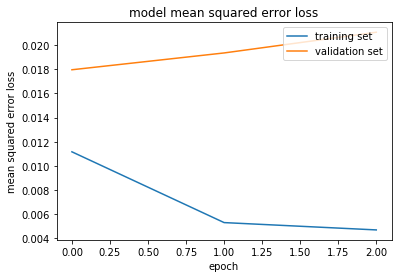

In [3]:
######################################################################################################################
### Final Model.py to training the model on Advanced Network with all the layers, pre-processing and Augumentation ###
######################################################################################################################

import csv
import cv2
import numpy as np
from keras.layers import Input, Flatten, Dense, Activation, Dropout, ELU
from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2, activity_l2
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle

#simulate different brightness occasions by converting image to HSV channel and randomly scaling the V channel.
def transform_brightness(image):
    """
    apply random brightness on the image
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:,:,2] = image[:,:,2]*random_bright
    return image

## Data Augmuntation (Flip Images and steering angle)
augmented_images, augmented_angles = [], []
def data_augmuntation(images, angles):
    for image, angle in zip(images, angles):
        augmented_images.append(image)
        augmented_angles.append(angle)
        augmented_images.append(cv2.flip(image,1))
        augmented_angles.append(angle*-1.0)
    return augmented_images, augmented_angles

def data_flip(image, angle):
    augmented_images.append(image)
    augmented_angles.append(angle)
    # flip image (randomly)
    if np.random.randint(2) == 0: 
        augmented_images.append(cv2.flip(image,1))
        augmented_angles.append(angle*-1.0)
    return augmented_images, augmented_angles
     

Train_Path = 'DATA'
Val_Path = 'Val_DATA'

# Load CSV File for Training Data
lines = []
with open('DATA/driving_log.csv') as csvfile :
    reader = csv.reader(csvfile)
    for line in reader :
        lines.append(line)

# Load CSV File for Validation Data (This is Udacity provided sample data)     
Val_lines = []
with open('Val_DATA/driving_log.csv') as csvfile2 :
    reader = csv.reader(csvfile2)
    for line in reader :
        Val_lines.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(Val_lines, test_size=0.2)
#train_samples = lines
#validation_samples = Val_lines

        
Val_images = [] # Validation featuers
Val_measurments = [] # Validation labels

for line in validation_samples :
    Val_source_path = line[0] # to get the center image file name/paths
    Val_file_name = Val_source_path.split('/')[-1]
    Val_current_path = 'Val_DATA/IMG/'+Val_file_name
    Val_image = cv2.imread(Val_current_path)
    Val_image = transform_brightness(Val_image)
    Val_images.append(Val_image)
    Val_measurment = float(line[3]) # to get the steering angle from the csv file
    Val_measurments.append(Val_measurment)
    
X_Val = np.array(Val_images)
y_Val = np.array(Val_measurments)



def training_generator(samples, path, batch_size=128):
    num_samples = len(samples)
    no_of_epochs = num_samples / batch_size
    print("no_of_epochs=:",no_of_epochs)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]  
            images = []
            angles = []
            for batch_sample in batch_samples:
                correction = 0.20
                # get the Image and the Steering Angel for Training
                cam_location = np.random.choice(['center', 'left', 'right'])
                if cam_location == 'center':
                    name = path+'/IMG/'+batch_sample[0].split('/')[-1]
                    image = cv2.imread(name)
                    image = transform_brightness(image)
                    angle = float(batch_sample[3])
                    
                if cam_location == 'left':
                    name = path+'/IMG/'+batch_sample[1].split('/')[-1]
                    image = cv2.imread(name)
                    image = transform_brightness(image)
                    angle = float(batch_sample[3]) + correction
                    #image, angle = data_flip(image, angle)
                    
                if cam_location == 'right':
                    name = path+'/IMG/'+batch_sample[2].split('/')[-1]
                    image = cv2.imread(name)
                    image = transform_brightness(image)
                    angle = float(batch_sample[3]) - correction
                    #image, angle = data_flip(image, angle)
                
                image, angle = data_flip(image, angle)
                X_train = np.array(image)
                y_train = np.array(angle)
                #yield sklearn.utils.shuffle(X_train, y_train)
                yield X_train, y_train
                X_train, y_train = [], []
                

            
            
def val_generator(samples, path, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                # get the Features and the labels for Validation Data
                name = path+'/IMG/'+batch_sample[0].split('/')[-1] # to get the file name/paths
                #print("Val_Image_Path=",name)
                image = cv2.imread(name)
                #image = transform_brightness(image)
                #images.append(image) # Images from Center camera are appended into 'images'  
                angle = float(batch_sample[3])
                #angles.append(angle) # Steering angle for Center Image 
                
                X_val = np.array(image)
                y_val = np.array(angle)
                
                #if len(X_val) == batch_size:
                #yield sklearn.utils.shuffle(X_val, y_val)
                yield X_val, y_val
                x_val, y_val = [], []

print("Orginal Training Data Size:", len(train_samples))
print("Orginal Validation Data Size:", len(validation_samples))


# compile and train the model using the generator function
train_generator = training_generator(train_samples, Val_Path, batch_size=128)
#train_generator = training_generator(train_samples, Train_Path, batch_size=128)
#validation_generator = val_generator(validation_samples, Val_Path, batch_size=200)
#validation_generator = training_generator(validation_samples, Train_Path, batch_size=32)


#Define the N/W Modle #
#input_shape = X_train.shape[1:]
#print("Training I/P shape:",input_shape)

keep_prob = 0.3
ch, row, col = 3, 160, 320  #  image format

def Lenet_model(time_len=1):
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(row, col, ch),output_shape=(row, col, ch))) # Normalization of Images
    model.add(Cropping2D(cropping=((60,20),(0,0)))) # Cropping the top 60 and bottom 20 pixels of the images
    model.add(Convolution2D(6, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(6, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def nvidia_model(time_len=1):
    keep_prob = 0.3
    reg_val = 0.001
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((60,20),(0,0)))) # Cropping the top 60 and bottom 20 pixels of the images
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu', )) # W_regularizer=l2(reg_val)
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# Select a Model
model = nvidia_model()
#model = Lenet_model()

#history_object = model.fit(X_train, y_train, nb_epoch=3, batch_size=128, validation_data=(X_Val, y_Val), shuffle=True)
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2, validation_data=(X_Val, y_Val), nb_epoch=3)
#history_object = model.fit_generator(train_generator, samples_per_epoch=15000, validation_data=validation_generator, nb_val_samples=10000, nb_epoch=3)
model.save('model.h5')



### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

        

